### Initialize the environment

In [1]:
import theano
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
src_dir='../src' # source directory
run_dir_prefix='../MDBN_run/AML_Batch_' # directory with the results of previous runs
data_dir='../data' # directory with the data files

In [3]:
import sys
sys.path.insert(0, src_dir)
import rbm
import MDBN
import main

### Load the experiment results

In [4]:
run=1
date_time='2017-02-20_2053' # specify the date and time of the run in the format YYYY-MM-DD_HHMM
run_dir=run_dir_prefix+date_time
runfile='Exp_%s_run_%s.npz' % (date_time, run) # location of the experiment results
config, dbn_dict = MDBN.load_network(runfile, run_dir)

In [5]:
config

{u'dbns': {u'GE': {u'batchSize': 1,
   u'datafile': u'AML/AML_gene_expression_table2.csv.gz',
   u'epochs': [20, 800],
   'inputNodes': 19937,
   u'k': 1,
   u'lambdas': [0.0, 1.0],
   u'layersNodes': [400, 40],
   u'lr': [0.0005, 0.1],
   u'persistent': False},
  u'ME': {u'batchSize': 1,
   u'datafile': u'AML/AML_miRNA_Seq_table2.csv.gz',
   u'epochs': [20],
   'inputNodes': 559,
   u'k': 10,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [40],
   u'lr': [0.005],
   u'persistent': False},
  u'SM': {u'batchSize': 1,
   u'datafile': u'AML/AML_somatic_mutations_table2.csv.gz',
   u'epochs': [20, 800],
   'inputNodes': 1686,
   u'k': 1,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [200, 20],
   u'lr': [0.01, 0.1],
   u'persistent': False}},
 u'p': 0.5,
 u'pathways': [u'ME', u'GE', u'SM'],
 u'runs': 4,
 u'seed': 1234,
 u'top': {u'batchSize': 1,
  u'epochs': [800, 800],
  'inputNodes': 100,
  u'k': 1,
  u'layersNodes': [24, 3],
  u'lr': [0.1, 0.1],
  u'persistent': False},
 u'uuid': u'1b702

### Load the data

In [6]:
datafiles = main.prepare_TCGA_datafiles("AML",config,data_dir)

#### Compute the joint layer components

In [7]:
dbn_output_list=[]
for key in config['pathways']:
    dbn_output, _ = dbn_dict[key].MLP_output_from_datafile(datafiles[key], datadir=data_dir)
    dbn_output_list.append(dbn_output)

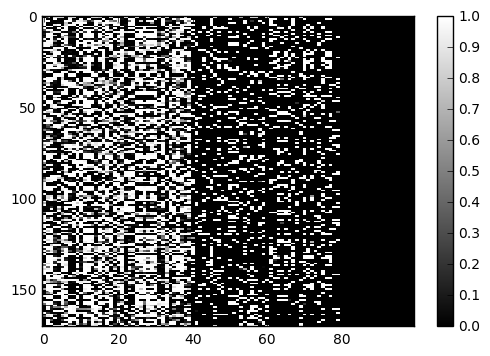

In [8]:
joint_layer = np.hstack(dbn_output_list[:2]+[np.zeros(dbn_output_list[2].shape,dtype=theano.config.floatX)])
#joint_layer = np.concatenate(dbn_output_list,axis=1)
plt.imshow(joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

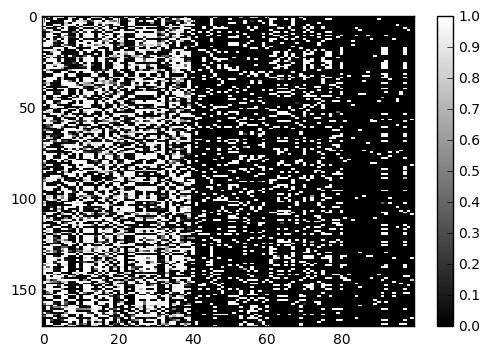

In [9]:
real_joint_layer = np.concatenate(dbn_output_list,axis=1)
plt.imshow(real_joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

In [10]:
top_output = dbn_dict['top'].get_output(theano.shared(joint_layer,borrow=True))

([<matplotlib.axis.XTick at 0x12b687b50>,
 <a list of 3 Text xticklabel objects>)

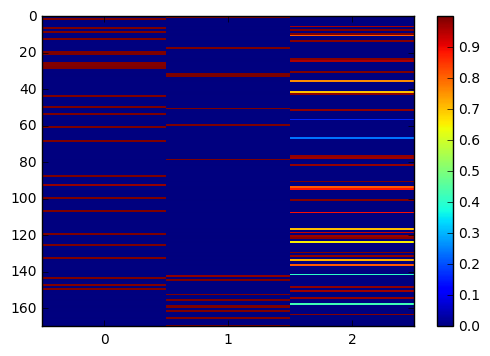

In [11]:
plt.imshow(top_output, interpolation='none',extent=[0,3,170,0])
plt.axis('tight')
plt.colorbar()
plt.xticks(np.arange(0.5,3.5,1),('0','1','2'))

([array([ 145.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   25.]),
  array([ 154.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   16.]),
  array([ 133.,    1.,    1.,    0.,    2.,    0.,    1.,    4.,    5.,   23.])],
 array([  3.55192472e-24,   9.99927104e-02,   1.99985421e-01,
          2.99978131e-01,   3.99970841e-01,   4.99963552e-01,
          5.99956262e-01,   6.99948972e-01,   7.99941683e-01,
          8.99934393e-01,   9.99927104e-01]),
 <a list of 3 Lists of Patches objects>)

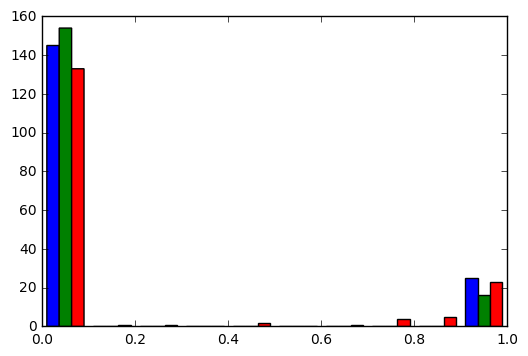

In [12]:
plt.hist(top_output)

In [13]:
top_dbn_rbm1 = dbn_dict['top'].rbm_layers[1]

In [14]:
reload(rbm)
middle_layer = top_dbn_rbm1.reverse_sampling(1,theano.shared(top_output,borrow=True))

 ... computing sample 0


(array([ 1559.,  1544.,   601.,   165.,     9.,    58.,     9.,     7.,
            0.,   128.]),
 array([  1.30668341e-04,   1.00117602e-01,   2.00104535e-01,
          3.00091468e-01,   4.00078401e-01,   5.00065334e-01,
          6.00052267e-01,   7.00039201e-01,   8.00026134e-01,
          9.00013067e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

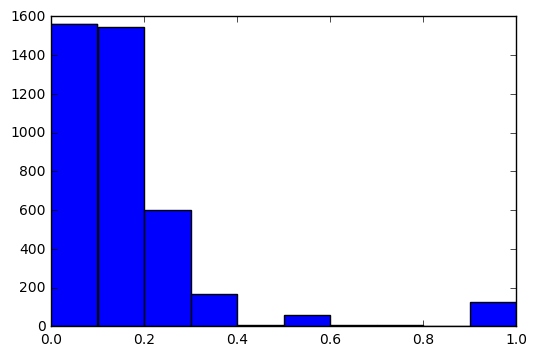

In [17]:
plt.hist(middle_layer)

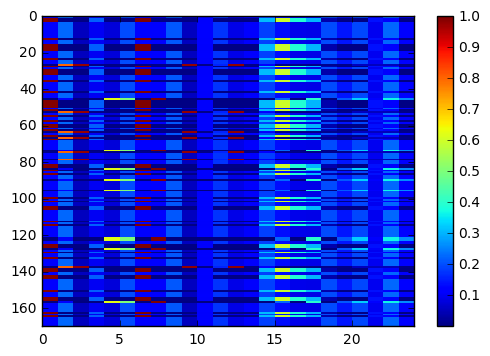

In [18]:
plt.imshow(middle_layer[0], interpolation='none',extent=[0,24,170,0])
plt.axis('tight')
plt.colorbar()

In [19]:
top_dbn_rbm0 = dbn_dict['top'].rbm_layers[0]

In [20]:
sampled_joint_layer = top_dbn_rbm0.reverse_sampling(1,theano.shared(middle_layer[0],borrow=True))

 ... computing sample 0


(-0.5, 99.5, 169.5, -0.5)

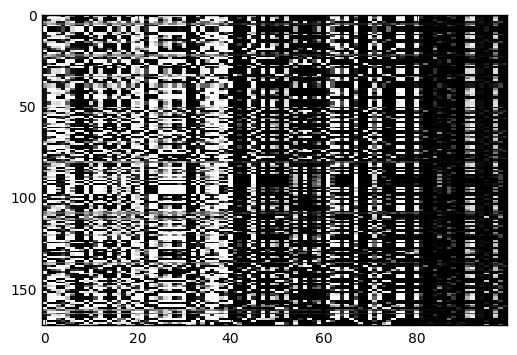

In [21]:
plt.imshow(sampled_joint_layer[0], cmap='gray',interpolation='none')
plt.axis('tight')

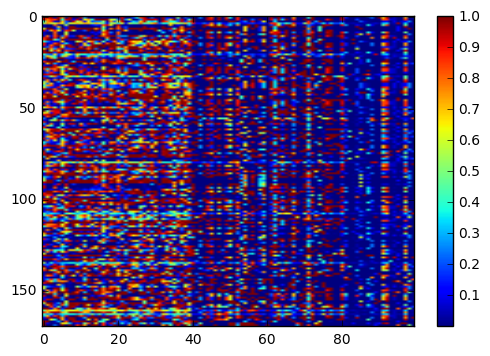

In [22]:
plt.imshow(np.sqrt(np.square(real_joint_layer-sampled_joint_layer[0])))
plt.axis('tight')
plt.colorbar()

In [23]:
me_rbm = dbn_dict['ME'].rbm_layers[0]

In [24]:
top_layer = sampled_joint_layer[0][:,:40]

In [25]:
vis_layer = me_rbm.reverse_sampling(1,theano.shared(top_layer,borrow=True))

 ... computing sample 0


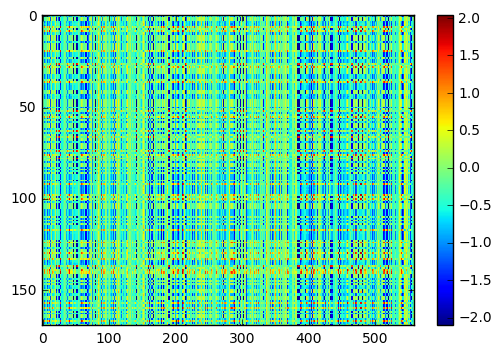

In [26]:
plt.imshow(vis_layer[0],interpolation='none')
plt.axis('tight')
plt.colorbar()

In [27]:
import utils
me_set, _ = utils.load_n_preprocess_data(datafiles['ME'],datadir=data_dir)

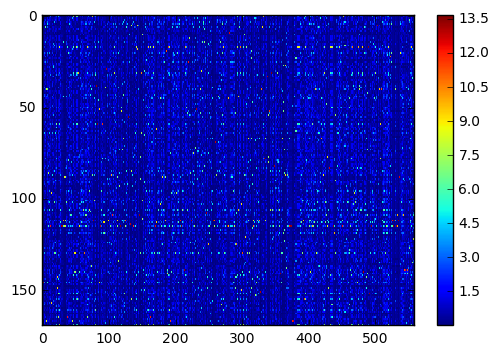

In [28]:
plt.imshow(np.sqrt(np.square(me_set.get_value()-vis_layer[0])),interpolation='none')
plt.axis('tight')
plt.colorbar()

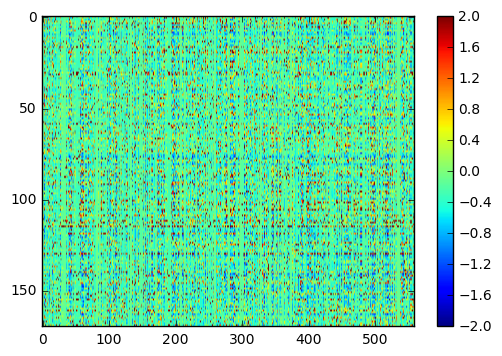

In [29]:
plt.imshow(me_set.get_value(),clim=(-2,2))
plt.axis('tight')
plt.colorbar()

/Users/gluca/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_axes.py:5907: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 170 x 559)
  '(shape is %d x %d)' % inp.shape[::-1])


([array([ 166.,    0.,    0.,    0.,    4.,    0.,    0.,    0.,    0.,    0.]),
  array([ 169.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
  array([ 164.,    1.,    2.,    0.,    1.,    2.,    0.,    0.,    0.,    0.]),
  array([ 128.,   35.,    6.,    1.,    0.,    0.,    0.,    0.,    0.,    0.]),
  array([ 149.,   17.,    3.,    0.,    1.,    0.,    0.,    0.,    0.,    0.]),
  array([ 89.,  71.,   3.,   2.,   5.,   0.,   0.,   0.,   0.,   0.]),
  array([ 165.,    3.,    0.,    0.,    0.,    0.,    2.,    0.,    0.,    0.]),
  array([ 129.,   35.,    3.,    1.,    2.,    0.,    0.,    0.,    0.,    0.]),
  array([ 159.,    5.,    4.,    2.,    0.,    0.,    0.,    0.,    0.,    0.]),
  array([ 152.,   14.,    2.,    0.,    1.,    1.,    0.,    0.,    0.,    0.]),
  array([ 89.,  71.,   4.,   3.,   2.,   1.,   0.,   0.,   0.,   0.]),
  array([ 125.,   39.,    3.,    2.,    1.,    0.,    0.,    0.,    0.,    0.]),
  array([ 156.,   10.,    3.,    0.,    0.,    0

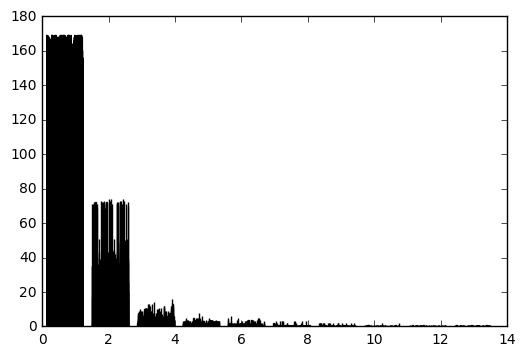

In [30]:
plt.hist(np.sqrt(np.square(me_set.get_value()-vis_layer[0])))